In [1]:
import cv2 
import numpy as np
import matplotlib.pylab as plt
import math 
from function import Region
from function import Image
from function import Contour
def showC(img):
    rgb = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    plt.imshow(rgb,cmap="gray")
    
def show(img):
    plt.imshow(img,cmap="gray")

# **Examination 1**
For Box 3kg .
### **Find Location**
1. Find Box Location -> calculate with, height, area
2. Find Top Surface Location
3. Find Bottom Surface Location
4. Find Middle Gap Location
5. Find Label Location Location
6. Find Marking Location

### **Find Edge, Line**
1. Find 4 edge of left and right side.
2. Find gap line 

### **Find Intersection**
1. Find 4 point Intersection between edge line and middle gap line

### **Calculate Distance**
1. Find distance between pair left corner point and pair right corner point (
vertical, horizontal, Euclidean distance )
2. Find width, height of marking
3. Find distance from marking corner to edge of label 

### **Make Defect Assumption**
 By the way create tolerance, offset and stardard size based on the real size 

*Note*:  Using Box location as well as ROI for all process

Knowledge received
1. Color Convertion
2. Color Extraction
3. Thresholding ( Global threhsold, Adaptive Threshold, Binary threshold )
4. Bitwise Operation (And, Or, Xor, Not)
5. Edge Detection ( Sobel (Find Edge Negative, Find Edge Positive))
6. Create ROI
7. Calc Distance in 2-Dimention
8. Some shape features ( area, with, height, squreness, circularity)
9. Shape/contour transformation (ConvexHull, FillUp, Approximate)
10. SelectShapeStd and SelectShape (understand some of shape features of object )
11. Morphological ( Opening, Closing, Erodde, Dilate) with struct element specially kernel
12. Contour feature and function related to contour (ConvexHull)
13. Utilize drawContour function as well as create ROI function
14. Utilize draw object (2-Dimention) as well as drawLine, drawCircle, drawRectangle

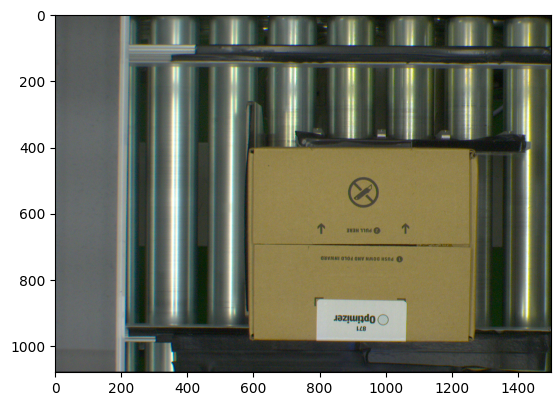

In [2]:
img = cv2.imread("images/3kg_Optimizer.bmp")
gray =cv2.imread("images/3kg_Optimizer.bmp",0)
showC(img)

# Find Box Location

index:331


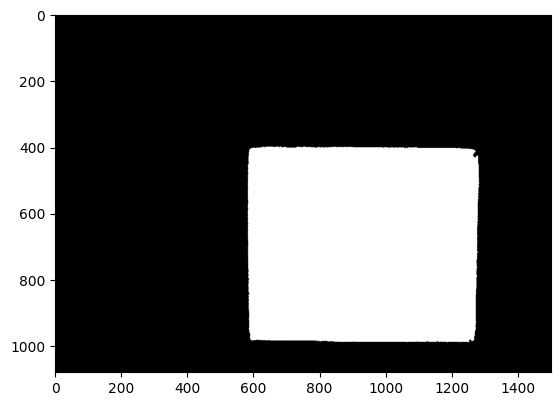

In [3]:
hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
h_low = 14
s_low = 73
v_low = 73

h_high = 52 
s_high = 255
v_high = 223

mask = cv2.inRange(hsv, np.array([h_low, s_low, v_low]),np.array([h_high, s_high, v_high]))
fillUp = Region.FillUp(mask)
opening_rectangle = Region.OpeningRectangle(fillUp, 3,3)
biggest_region = Region.SelectShapeStd(opening_rectangle, mode = "area")


show(biggest_region)
box_location = biggest_region

## BOX_SIZE

* Assumsion: widht [690: 700] 
* Assumsion: height [600: 610] 

In [4]:
x, y, w,h = cv2.boundingRect(biggest_region)
print(w,h)
is_defect = False

if w <=700 or w >= 690:
    is_defect = True

if h <=610 or h >= 600:
    is_defect = True
    
if is_defect:
    print("BOX_SIZE")
    # Send message -> PLC (BOX_SIZE)
else:
    print("PASS")
    # Send message -> PLC (PASS)
    

698 590
BOX_SIZE


## Find Middle Gap (Region) 
* Gap Line

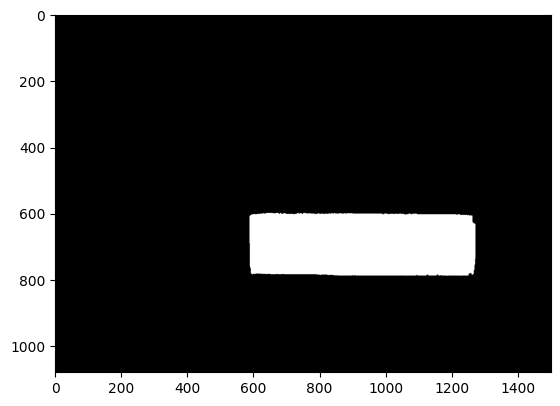

In [5]:
middlegap_region = Region.ErodeRectangle(biggest_region, 1, 200)
show(middlegap_region)

## Draw Rectangle on Empty mask (color = (255,255,255))

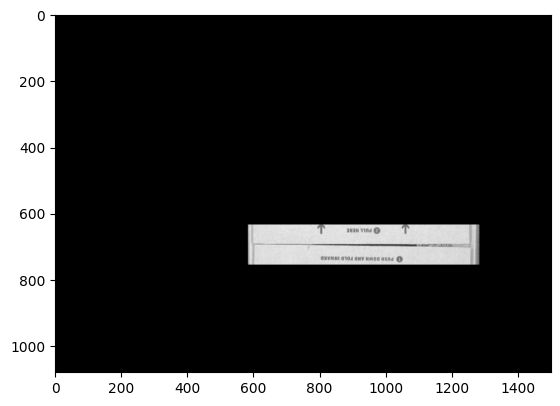

In [6]:
center_x = x + w /2 
center_y = y + h /2 

OFFSET = 60

top_left  = ( int(x), int(center_y - OFFSET))
bottom_right = ( int(x+w),int(center_y+  OFFSET))

mask = np.zeros((img.shape[0], img.shape[1]), dtype = np.uint8)
cv2.rectangle(mask, top_left, bottom_right, (255,255,255), -1)

gray_reduce = cv2.bitwise_and(gray, mask, mask =None)
show(gray_reduce)

index:80
index:101


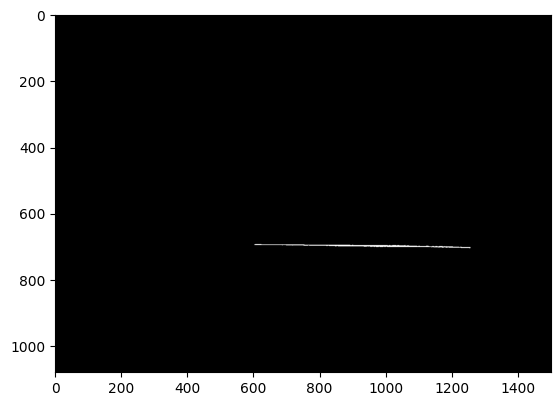

In [7]:
midlegap_image = cv2.bitwise_and(gray,middlegap_region, mask = middlegap_region)
sobel = cv2.Sobel(midlegap_image, cv2.CV_64F, 0,1 , ksize = 3)

_,edge_negative_possible = cv2.threshold(sobel, 30, 255, cv2.THRESH_BINARY)
_,edge_positive_possible = cv2.threshold(sobel, -30, 255, cv2.THRESH_BINARY_INV)

middlegap_erode = Region.ErodeRectangle(middlegap_region, 1, 15)

edge_negative_possible = cv2.bitwise_and(edge_negative_possible.astype(np.uint8),middlegap_erode, mask = middlegap_erode)
edge_positive_possible = cv2.bitwise_and(edge_positive_possible.astype(np.uint8),middlegap_erode, mask = middlegap_erode)


edge_negative = Region.ClosingRectangle(edge_negative_possible, 3, 1)
edge_negative = Region.SelectShapeStd(edge_negative, mode= "width")


edge_postive = Region.ClosingRectangle(edge_positive_possible, 3, 1)
edge_postive = Region.SelectShapeStd(edge_postive, mode= "width")

show(edge_negative)

## Hough Line

In [8]:
line_negative = cv2.HoughLinesP(edge_negative.astype(np.uint8), 1,np.pi / 180, 500,minLineLength = 100, maxLineGap = 2000)
line_negative


line_positive = cv2.HoughLinesP(edge_postive.astype(np.uint8), 1,np.pi / 180, 500,minLineLength = 100, maxLineGap = 2000)
line_positive

array([[[ 600,  693, 1250,  693]],

       [[ 599,  692, 1250,  692]],

       [[ 637,  694, 1249,  694]]], dtype=int32)

In [9]:
line_negative[0][0] # x1,y2, x2, y2
point1 = (line_negative[0][0][0], line_negative[0][0][1])
point2 = (line_negative[0][0][2], line_negative[0][0][3])

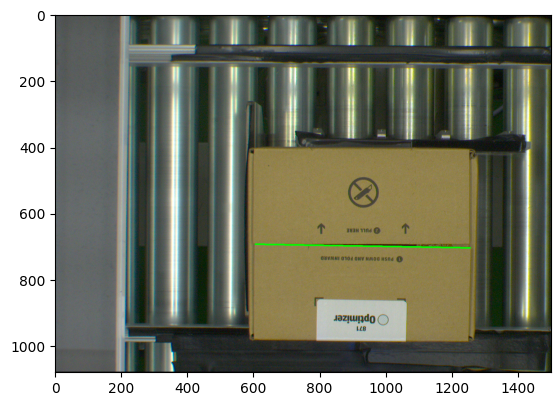

In [10]:
img_copy = img.copy()
cv2.line(img_copy, point1, point2 , (0,255,0) , 3)
showC(img_copy)

In [11]:
line_positive[0][0] # x1,y2, x2, y2
point3 = (line_positive[0][0][0], line_positive[0][0][1])
point4 = (line_positive[0][0][2], line_positive[0][0][3])

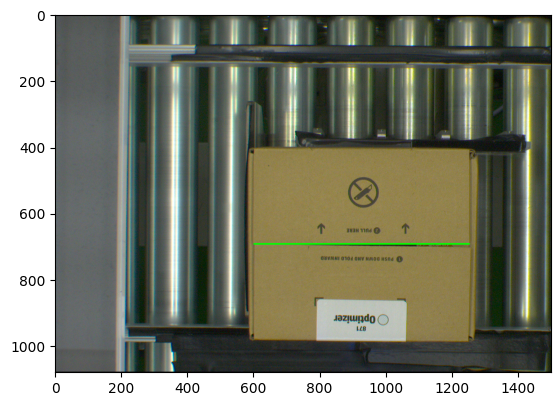

In [12]:
img_copy = img.copy()
cv2.line(img_copy, point3, point4 , (0,255,0) , 3)
showC(img_copy)

## Find Edge (4 Edge)

In [13]:
center_x  =  x + w / 2 
center_y  =  y + h / 2 
print(center_x, center_y)

931.0 695.0


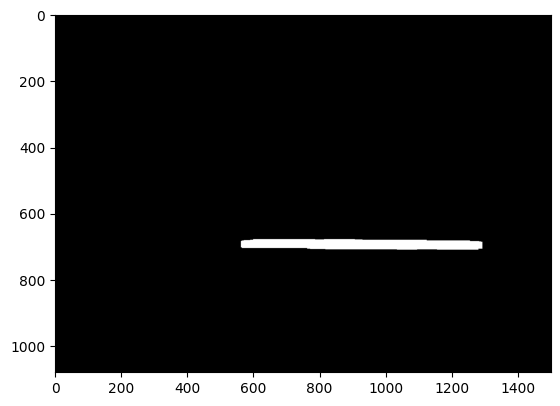

In [14]:
middlegap_2 = Region.ErodeRectangle(biggest_region, 1, 280)
middlegap_2 = Region.DilationRectangle(middlegap_2, 30, 1)

show(middlegap_2)

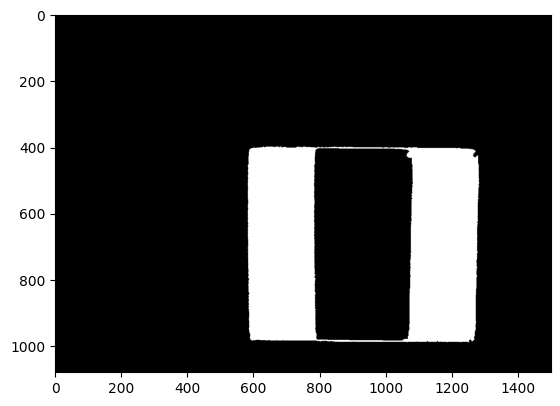

In [15]:
erode_ox = Region.ErodeRectangle(biggest_region, 200, 1)
show(erode_ox)
diff_ox = cv2.bitwise_xor(biggest_region,erode_ox, mask = biggest_region)
show(diff_ox)

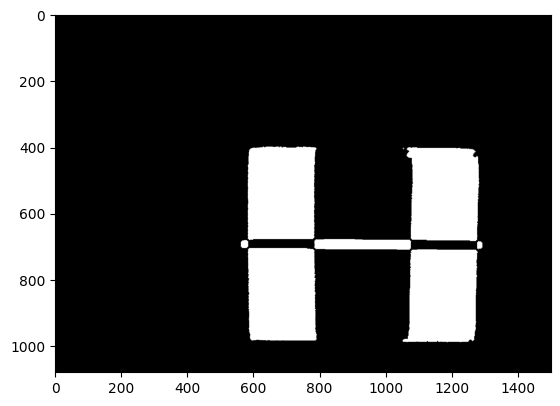

In [16]:
edges = cv2.bitwise_xor(diff_ox, middlegap_2, mask =None)
opening_rectangle = Region.OpeningRectangle(edges, 5,5)
opening_circle = Region.OpeningCircle(edges, 3)
show(opening_circle)

4


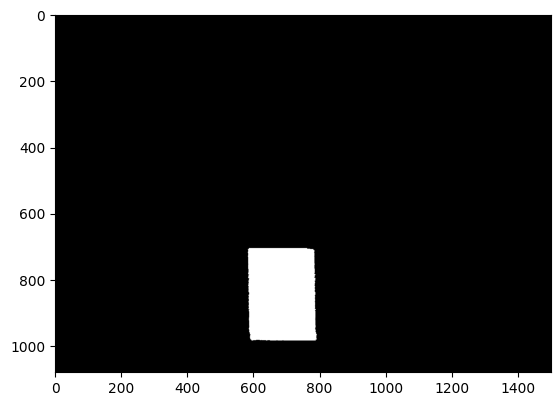

In [17]:
_, list_select_shape ,_ = Region.SelectShape(opening_circle.astype(np.uint8), min_value=200, max_value=350, feature="height")
print(len(list_select_shape))
show(list_select_shape[2])

index:6


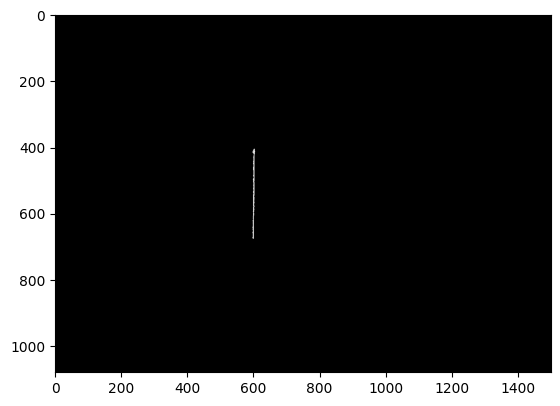

In [18]:
edge_1  = cv2.bitwise_and(gray, list_select_shape[0])
edge_2  = cv2.bitwise_and(gray, list_select_shape[1])
edge_3  = cv2.bitwise_and(gray, list_select_shape[2])
edge_4  = cv2.bitwise_and(gray, list_select_shape[3])

sobel_1 = cv2.Sobel(edge_1, cv2.CV_64F, 1,0 , ksize = 3)
_, edge_negative_1 = cv2.threshold(sobel_1, 25, 255, cv2.THRESH_BINARY)
mask_1 = Region.ErodeRectangle(list_select_shape[0], 10, 1)

edge_negative_1 = cv2.bitwise_and(edge_negative_1.astype(np.uint8), mask_1)
edge_negative_1 = Region.SelectShapeStd(edge_negative_1, mode ="area")

show(edge_negative_1)

#[edge_negative_1, edge_negative_2, edge_negative_3, edge_negative_4]


index:6
index:32
index:1
index:7


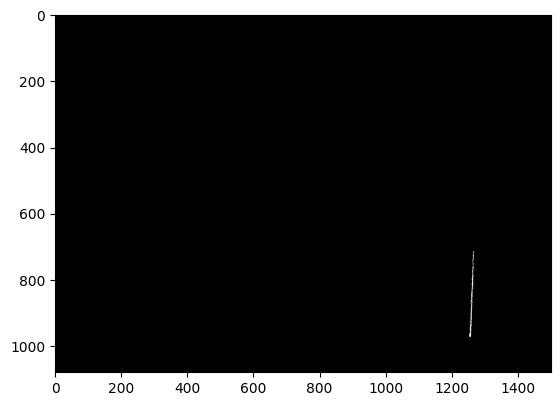

In [19]:
def get_edge(gray, list_mask):
    list_edge = []
    for mask in list_mask: 
        edge_1  = cv2.bitwise_and(gray, mask)
        sobel_1 = cv2.Sobel(edge_1, cv2.CV_64F, 1,0 , ksize = 3)
        _, edge_negative_1 = cv2.threshold(sobel_1, 25, 255, cv2.THRESH_BINARY)
        mask_1 = Region.ErodeRectangle(mask, 10, 1)

        edge_negative_1 = cv2.bitwise_and(edge_negative_1.astype(np.uint8), mask_1)
        edge_negative_1 = Region.SelectShapeStd(edge_negative_1, mode ="area")
        
        list_edge.append(edge_negative_1)
    
    return list_edge
list_edge = get_edge(gray,list_select_shape)

show(list_edge[3])

In [20]:
lines = cv2.HoughLinesP(list_edge[0], 1,np.pi / 180, 200,minLineLength = 100, maxLineGap = 2000)
lines =np.squeeze(lines, axis =1)
lines[0][0]
point1 = (lines[0][0], lines[0][1])
point2 = (lines[0][2], lines[0][3])

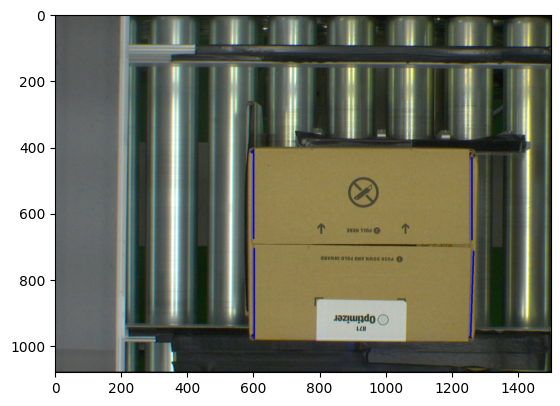

In [21]:
img_copy = img.copy()
for edge in list_edge:
    
    lines = cv2.HoughLinesP(edge.astype(np.uint8), 1,np.pi / 180, 200,minLineLength = 100, maxLineGap = 2000)
    lines =np.squeeze(lines, axis =1)
    point1 = (lines[0][0], lines[0][1])
    point2 = (lines[0][2], lines[0][3])
    
    cv2.line(img_copy, point1, point2, (255,0,0), 3)
    
showC(img_copy)

## Intersection -> 4 Corner 


599.0 693.0
1258.0 693.0
601.0 693.9491525423729
1263.3413996075867 705.1752779594506


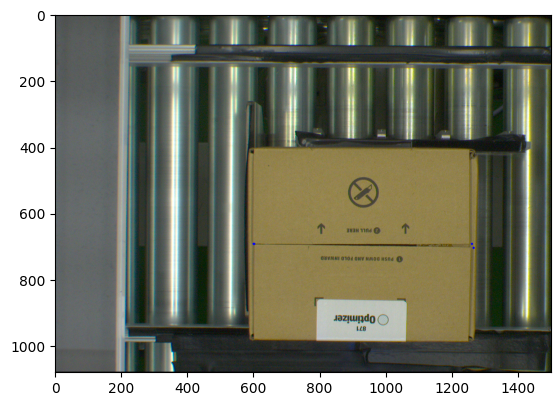

In [22]:
img_copy = img.copy()

right_corner= []
left_corner = []
for index, edge in  enumerate(list_edge):
    
    # Edge 
    lines = cv2.HoughLinesP(edge.astype(np.uint8), 1,np.pi / 180, 200,minLineLength = 100, maxLineGap = 2000)
    lines =np.squeeze(lines, axis =1)
    point1 = (lines[0][0], lines[0][1])
    point2 = (lines[0][2], lines[0][3])
    
    A_edge, B_edge, C_edge = Contour.find_formula_line(point1, point2)
    
    # Midle Line
    if index ==0 or index ==1 :
        line_positive[0][0] # x1,y2, x2, y2
        point3 = (line_positive[0][0][0], line_positive[0][0][1])
        point4 = (line_positive[0][0][2], line_positive[0][0][3])
        A_gapline, B_gapline, C_gapline = Contour.find_formula_line(point3, point4)
        # line 1 
        
    if index ==2 or index ==3 :
        line_positive[0][0] # x1,y2, x2, y2
        point3 = (line_negative[0][0][0], line_negative[0][0][1])
        point4 = (line_negative[0][0][2], line_negative[0][0][3])
        A_gapline, B_gapline, C_gapline = Contour.find_formula_line(point3, point4)
            

    x_intersection , y_intersection= Contour.line_intersection(
        (A_edge, B_edge, C_edge), 
        (A_gapline, B_gapline, C_gapline)
    )
    
    if index == 0 or index ==2:
        left_corner.append(
            (int(x_intersection), int(y_intersection))
        )
        
    elif index==1 or index ==3:
        right_corner.append(
            (int(x_intersection), int(y_intersection))
        )
        
    print(x_intersection, y_intersection)
    cv2.circle(img_copy, (int(x_intersection), int(y_intersection)), 2, (255,0,0), 2)
    
showC(img_copy)

## Calclate Distance left and right corner

In [23]:
print(left_corner)
print(right_corner)

[(599, 693), (601, 693)]
[(1258, 693), (1263, 705)]


In [24]:
p1  = left_corner[0]
p2  = left_corner[1]
d_left = math.sqrt ((p1[0] - p2[0]) **2 + (p1[1] - p2[1])**2)
print(d_left)

2.0


In [25]:
p1  = right_corner[0]
p2  = right_corner[1]
d_right = math.sqrt ((p1[0] - p2[0]) **2 + (p1[1] - p2[1])**2)
print(d_right)

13.0


In [26]:
defect = "gap_distance"
"""
    d_left: [5:10]
    d_right: [6:11 ]
"""
is_gap_distance = True
if d_left >= 5 and d_left_<=10 :
    is_gap_distance = False
    
if d_right >= 6 and d_right<=11 :
    is_gap_distance = False
    
if is_gap_distance:
    print("GAP_DISTANCE")
    # send PLC
else:
    print("PASS")
    # send PLC

GAP_DISTANCE


# **Label Location**

index:1


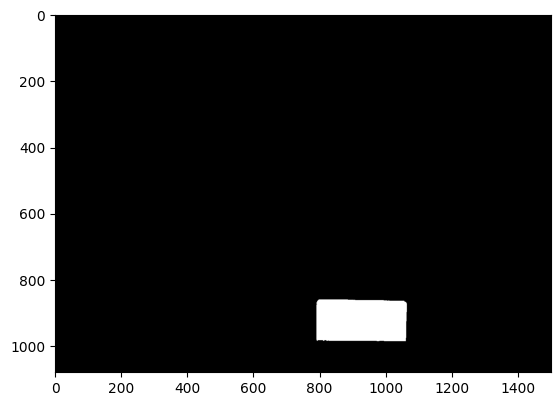

In [27]:
hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
h_low = 0
s_low = 0
v_low = 160

h_high = 208 
s_high = 172
v_high = 255

mask = cv2.inRange(hsv, np.array([h_low, s_low, v_low]),np.array([h_high, s_high, v_high]))
fillUp = Region.FillUp(mask)
opening_rectangle = Region.OpeningRectangle(fillUp, 3,3)

fillUp = cv2.bitwise_and(box_location, opening_rectangle)

label_location = Region.SelectShapeStd(fillUp, mode = "area")


show(label_location)

# **Template Matching**

### Load Template

In [58]:
list_template = []
list_crop_size = []
number_template = 6
for i in range(1,number_template+1):
    path = f"images/bai22_template{i}.png"
    template = cv2.imread(path, 0)
    list_crop_size.append( (template.shape[1], template.shape[0]))
    list_template.append(template)
    
print(len(list_template))
print(list_crop_size)

6
[(99, 104), (267, 46), (36, 46), (126, 36), (31, 45), (137, 65)]


### Matching and draw rectangle on Image

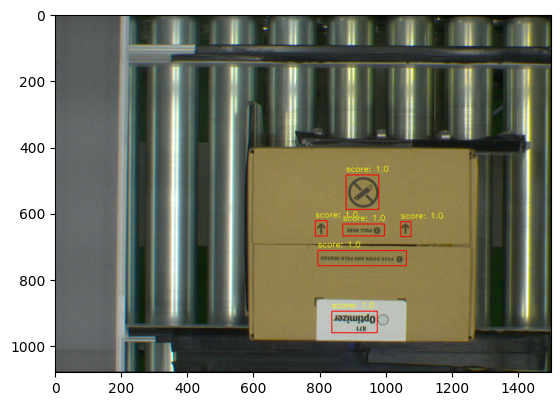

In [59]:
THRESH  = 0.95
methods = [ cv2.TM_SQDIFF_NORMED, # mode tính correlation cofficient theo squared difference
            cv2.TM_CCORR_NORMED, # mode tính correlation cofficient theo khoảng cách cosine
            cv2.TM_CCOEFF_NORMED, # mode tính correlation cofficient theo khoảng cách correlation cofficient 
           ] 
           

img_copy = img.copy()

for method in methods:
    for template, (w_crop, h_crop) in zip(list_template, list_crop_size):
        res = cv2.matchTemplate(gray,template,method)

        min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)
        """
        min_val: min score
        max_val: max score

        min_loc: toa do top_left
        max_loc: tao do bottom_right

        """
        if max_val >= THRESH:
            if method in [cv2.TM_SQDIFF, cv2.TM_SQDIFF_NORMED]:
                top_left = min_loc
            else:
                top_left = max_loc
                
            bottom_right = (top_left[0] + w_crop,top_left[1] + h_crop)

            img_copy = cv2.rectangle(img_copy, top_left, bottom_right, (0,0,255), 2)

            position = (top_left[0],top_left[1] -10)
            
            img_copy = cv2.putText(img_copy, f'score: {round(max_val,2)}', position, cv2.FONT_HERSHEY_SIMPLEX,
                        0.8, (0,255,255), 1, cv2.LINE_AA)

showC(img_copy)

# **Marking Location**

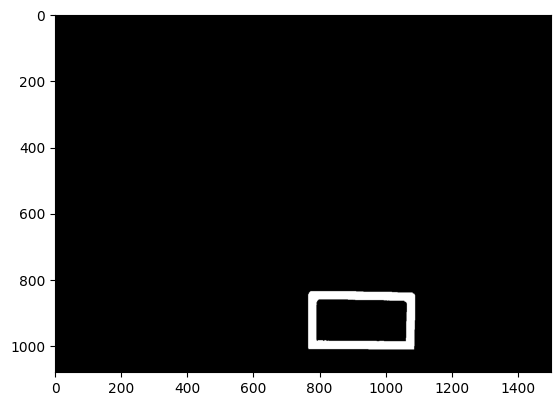

In [28]:
marking_over = Region.DilationRectangle(label_location,25,25)
marking_location =cv2.bitwise_xor(marking_over, label_location)
show(marking_location)

number of marking: 2


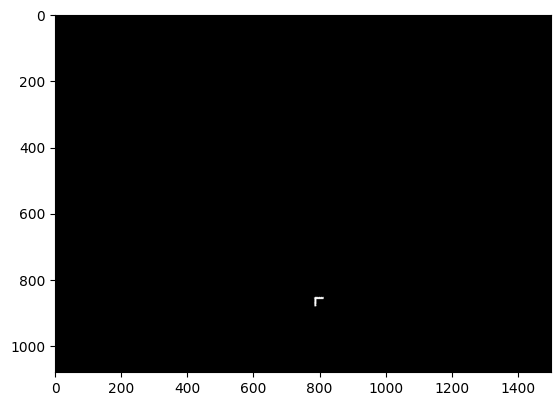

In [29]:
marking_gray = cv2.bitwise_and(marking_over, gray)
_, threshold =cv2.threshold(marking_gray, 120,255, cv2.THRESH_BINARY)
threshold_not = cv2.bitwise_not(threshold)
threshold_not = Region.OpeningRectangle(threshold_not, 1,1 )



marking_posiable = cv2.bitwise_and(threshold_not, marking_location)
marking_union,marking,_ = Region.SelectShape(marking_posiable, min_value= 10, max_value= 80, feature="width")
print(f'number of marking: {len(marking)}')
show(marking[0])

### Find Corner of Marking

In [30]:
x_left_marking, y_left_marking,_,_ = cv2.boundingRect(marking[0])
x_right_marking, y_right_marking,_,_  = cv2.boundingRect(marking[1])
print(x_left_marking, y_left_marking)
print(x_right_marking, y_right_marking)

781 853
1031 856


# **Marking Distance**

### Find Horizontal Edge of Lable (1 Line) and Draw it on Image

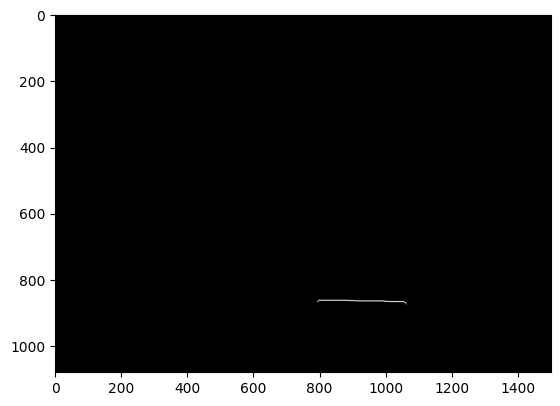

In [31]:
label_location_erode = Region.ErodeRectangle(label_location, 0,3)
label_edge_posiable = cv2.bitwise_xor(label_location, label_location_erode)
label_edge_horizontal = Region.OpeningRectangle(label_edge_posiable,1,2)

edge_horizontal,list_edge_horizontal,_ = Region.SelectShape(label_edge_horizontal, min_value= 200, max_value= 300, feature="width")

show(list_edge_horizontal[0])

edge_horizontal = list_edge_horizontal[0]

In [32]:
line_horizontal= cv2.HoughLinesP(edge_horizontal, 1,np.pi / 180, 200,minLineLength = 100, maxLineGap = 2000)
line_horizontal =np.squeeze(line_horizontal, axis=1)
line_horizontal = line_horizontal[0]
print(line_horizontal)
point1 = (line_horizontal[0], line_horizontal[1])
point2 = (line_horizontal[2], line_horizontal[3])

A_horizontal , B_horizontal , C_horizontal = Contour.find_formula_line(point1,point2)

[ 795  863 1054  867]


### Find Vertical Edge of Lable (1 Line) and Draw it on Image

Number edge vertical: 2


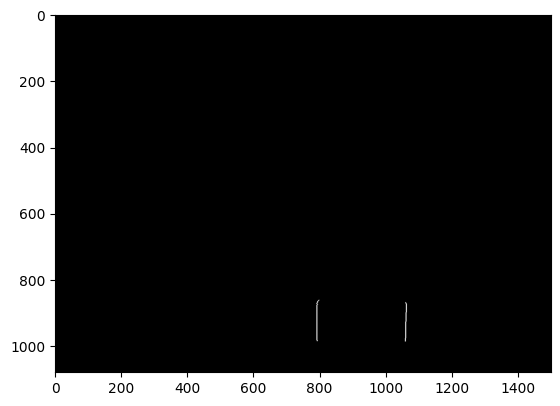

In [34]:
label_location_erode = Region.ErodeRectangle(label_location, 3,0)
label_edge_posiable = cv2.bitwise_xor(label_location, label_location_erode)
label_edge_vertical = Region.OpeningRectangle(label_edge_posiable,1,2)

edge_vertical,list_edge_vertical,_ = Region.SelectShape(label_edge_vertical, min_value= 50, max_value= 150, feature="height")
print(f'Number edge vertical: {len(lis_edge_vertical)}')
show(edge_vertical)

edge_vertical_left = list_edge_vertical[0]
edge_vertical_right = list_edge_vertical[1]

In [35]:
line_vertical = cv2.HoughLinesP(edge_vertical_left, 1,np.pi / 180, 100,minLineLength = 100, maxLineGap = 2000)
line_vertical =np.squeeze(line_vertical, axis=1)
line_vertical = line_vertical[0]


print(line_vertical)
point3 = (line_vertical[0], line_vertical[1])
point4 = (line_vertical[2], line_vertical[3])

A_vertical_left , B_vertical_left , C_vertical_left = Contour.find_formula_line(point3,point4)
print(A_vertical_left , B_vertical_left , C_vertical_left)

[791 986 791 867]
1 0 -791


In [36]:
line_vertical = cv2.HoughLinesP(edge_vertical_right, 1,np.pi / 180, 100,minLineLength = 100, maxLineGap = 2000)
line_vertical =np.squeeze(line_vertical, axis=1)
line_vertical = line_vertical[0]


print(line_vertical)
point5 = (line_vertical[0], line_vertical[1])
point6 = (line_vertical[2], line_vertical[3])

A_vertical_right , B_vertical_right , C_vertical_right = Contour.find_formula_line(point5,point6)
print(A_vertical_right , B_vertical_right)

[1056  987 1060  872]
-28.75 -1


### Draw on Image

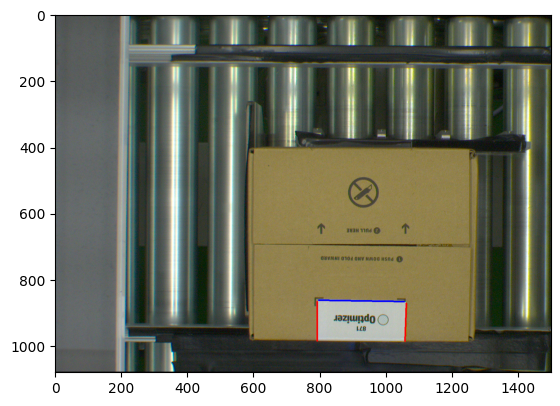

In [37]:
img_copy = img.copy()
cv2.line(img_copy, point1, point2, (255,0,0), 3)
cv2.line(img_copy, point3, point4, (0,0,255), 3)
cv2.line(img_copy, point5, point6, (0,0,255), 3)
showC(img_copy)

### Find Distance corner of marking (left marking and right marking )to edge 

In [41]:
"""
    Left marking:  x_left_marking, y_left_marking
    Right marking: x_right_marking, y_right_marking
"""
distance_left_horizontal = Contour.minimum_distance_point_to_line( (x_left_marking, y_left_marking) , (A_horizontal , B_horizontal , C_horizontal))
print(f' Distance from left marking to label based on Horizontal: {round(distance_left_horizontal,4)} (Pixel)')

distance_right_horizontal = Contour.minimum_distance_point_to_line( (x_right_marking, y_right_marking) , (A_horizontal , B_horizontal , C_horizontal))
print(f' Distance from right marking to label based on Horizontal: {round(distance_left_horizontal,4)} (Pixel)')


 Distance from left marking to label based on Horizontal: 9.7826 (Pixel)


In [44]:
distance_left_vertical = Contour.minimum_distance_point_to_line( (x_left_marking, y_left_marking) , (A_vertical_left , B_vertical_left , C_vertical_left))
print(f' Distance from left marking to label based on Vertical : {round(distance_left_vertical,4)} (Pixel)')

distance_right_vertical = Contour.minimum_distance_point_to_line( (x_right_marking, y_right_marking) , (A_vertical_right , B_vertical_right , C_vertical_right))
print(f' Distance from right marking to label based on Vertical: {round(distance_right_vertical,4)} (Pixel)')

 Distance from left marking to label based on Vertical : 10.0 (Pixel)
 Distance from right marking to label based on Vertical: 29.5387 (Pixel)
